In [1]:
import numpy, scipy, matplotlib.pyplot as plt, sklearn, IPython.display, librosa, urllib
plt.rcParams['figure.figsize'] = (14,4)

[&larr; Back to Index](index.html)

# Nonnegative Matrix Factorization

[Nonnegative matrix factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) (NMF) is an algorithm that factorizes a nonnegative matrix, $X$, into a product of two nonnegative matrices, $W$ and $H$. It is an unsupervised iterative algorithm that minimizes a distance between $X$ and the product $WH$:

$$ \min_{W, H} d(X, WH) $$

If $X$ has dimensions $M$ by $N$, then $W$ will have dimensions $M$ by $R$, and $H$ will have dimensions $R$ by $N$, where inner dimension $R$ is the *rank* or *number of components* of the decomposition.

When applied to a musical signal, we find that NMF can decompose the signal into separate note events. Therefore, NMF is quite useful and popular for tasks such as transcription and source separation.

The input, $X$, is often a magnitude spectrogram. In such a case, we find that the columns of $W$ represent spectra of note events, and the rows of $H$ represent temporal envelopes of the same note events.

Download an audio file:

In [2]:
filename = 'conga_groove.wav'
urllib.urlretrieve('http://audio.musicinformationretrieval.com/' + filename,
                  filename=filename)

('conga_groove.wav', <httplib.HTTPMessage instance at 0x109d4bd40>)

Let's load a signal:

In [3]:
x, fs = librosa.load(filename)
print fs

22050


Play the audio signal:

In [4]:
x[0] = 1 # hack to prevent automatic gain scaling
IPython.display.Audio(x, rate=fs)

Compute the spectrogram:

In [5]:
S = librosa.stft(x)
print S.shape

(1025, 188)


Display the spectrogram:

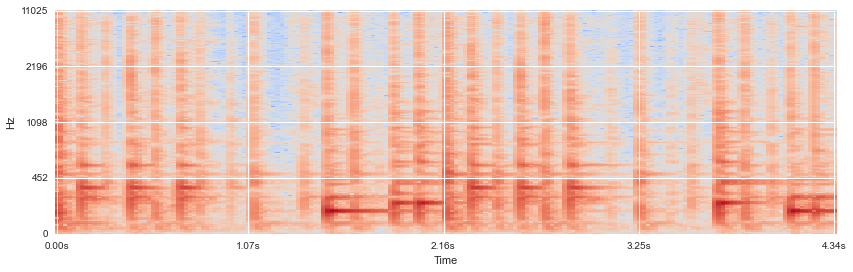

In [6]:
logX = librosa.logamplitude(S)
librosa.display.specshow(logX, sr=fs, x_axis='time', y_axis='log')

## `librosa.decompose.decompose`

We will use [`librosa.decompose.decompose`](http://bmcfee.github.io/librosa/generated/librosa.decompose.decompose.html) to perform our factorization. `librosa` uses [`sklearn.decomposition.NMF`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF) by default as its factorization method.

In [7]:
X = numpy.absolute(S)
n_components = 6
W, H = librosa.decompose.decompose(X, n_components=n_components, sort=True)
print W.shape
print H.shape

(1025, 6)
(6, 188)


Let's display the spectra:

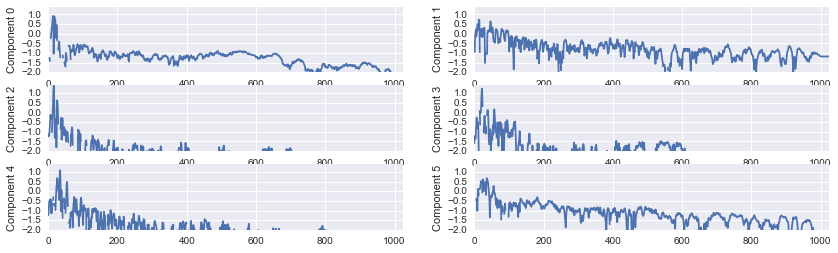

In [8]:
logW = numpy.log10(W)
for n in range(n_components):
    plt.subplot(numpy.ceil(n_components/2.0), 2, n+1)
    plt.plot(logW[:,n])
    plt.ylim(-2, logW.max())
    plt.xlim(0, W.shape[0])
    plt.ylabel('Component %d' % n)

Let's display the temporal activations:

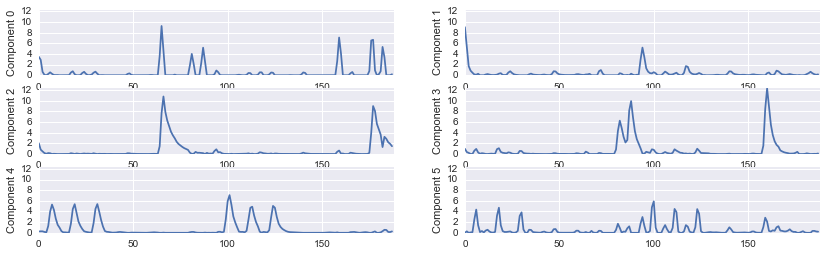

In [9]:
for n in range(n_components):
    plt.subplot(numpy.ceil(n_components/2.0), 2, n+1)
    plt.plot(H[n])
    plt.ylim(0, H.max())
    plt.xlim(0, H.shape[1])
    plt.ylabel('Component %d' % n)

Finally, re-create the individual components, and listen to them. To do this, we will reconstruct the magnitude spectrogram from the NMF outputs and use the phase spectrogram from the original signal.

In [10]:
reconstructed_signal = scipy.zeros(len(x))
for n in range(n_components):
    Y = scipy.outer(W[:,n], H[n])*numpy.exp(1j*numpy.angle(S))
    y = librosa.istft(Y)
    reconstructed_signal[:len(y)] += y
    IPython.display.display( IPython.display.Audio(y, rate=fs) )

Listen to the reconstructed full mix:

In [11]:
IPython.display.Audio(reconstructed_signal, rate=fs)

Listen to the residual:

In [12]:
residual = x - reconstructed_signal
residual[0] = 1 # hack to prevent automatic gain scaling
IPython.display.Audio(residual, rate=fs)

[&larr; Back to Index](index.html)